In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import sys
sys.path.append('..')
from src.dataset import load_dataset
from src.model import load_model
from src.utils import imshow

In [3]:
###############################################################
# Prepare dataset
###############################################################

trainset, testset, classes = load_dataset('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


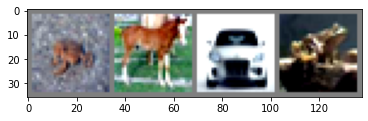

frog  horse car   frog 


In [4]:
###############################################################
# visualize random images from training set
###############################################################

# get some random training images
temp_trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
dataiter = iter(temp_trainloader)
images, labels = dataiter.next()

# show images
imshow(images)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
###############################################################
# Hyperparameters
###############################################################

batch_size = 32
num_epoch = 5

In [7]:
###############################################################
# Prepare dataloader
###############################################################

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
###############################################################
# Prepare model/loss/optimizer
###############################################################

model = load_model('baseline')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [9]:
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.945
[1,   400] loss: 1.719
[1,   600] loss: 1.571
[1,   800] loss: 1.540
[1,  1000] loss: 1.488
[1,  1200] loss: 1.429
[1,  1400] loss: 1.398
[2,   200] loss: 1.316
[2,   400] loss: 1.302
[2,   600] loss: 1.257
[2,   800] loss: 1.268
[2,  1000] loss: 1.268
[2,  1200] loss: 1.253
[2,  1400] loss: 1.244
[3,   200] loss: 1.168
[3,   400] loss: 1.156
[3,   600] loss: 1.150
[3,   800] loss: 1.163
[3,  1000] loss: 1.160
[3,  1200] loss: 1.138
[3,  1400] loss: 1.159
[4,   200] loss: 1.066
[4,   400] loss: 1.068
[4,   600] loss: 1.093
[4,   800] loss: 1.105
[4,  1000] loss: 1.066
[4,  1200] loss: 1.067
[4,  1400] loss: 1.089
[5,   200] loss: 0.999
[5,   400] loss: 1.022
[5,   600] loss: 1.012
[5,   800] loss: 1.039
[5,  1000] loss: 1.016
[5,  1200] loss: 1.004
[5,  1400] loss: 1.004
Finished Training


In [10]:
!mkdir -p ../untracked/model

model_path = '../untracked/model/cifar10_baseline.pth'
torch.save(model.state_dict(), model_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


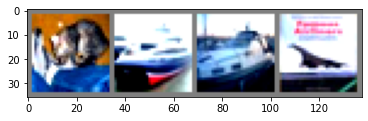

GroundTruth:  cat   ship  ship  plane


In [11]:
###############################################################
# visualize images from test set
###############################################################

temp_testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
dataiter = iter(temp_testloader)
images, labels = dataiter.next()

# print images
imshow(images)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
model = load_model('baseline', checkpoint='cifar10_baseline.pth')
model = model.to(device)

In [13]:
outputs = model(images.to(device))

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.9 %
Accuracy for class: car   is 74.7 %
Accuracy for class: bird  is 63.1 %
Accuracy for class: cat   is 30.5 %
Accuracy for class: deer  is 46.4 %
Accuracy for class: dog   is 57.8 %
Accuracy for class: frog  is 73.1 %
Accuracy for class: horse is 70.8 %
Accuracy for class: ship  is 75.0 %
Accuracy for class: truck is 67.1 %
